# Twitter Sentiment Analysis
**Author:** Christopher Varghese

## Business Problem
Twitter is one of the biggest social platforms to exist. Unlike its competitors such as facebook and instagram, the 'posts' on Twitter are small snippet messages, referred to as Tweets. These Tweets can often be categorized under a particular hashtag or contain key words that relate it to a certain topic. Therefore, developing a model that can extract sentiment from Tweets has a multitude of advantages for a business. First, it can be a tool to gather data on public opinion regarding a product or service. Second, it can be used to gather information on a competitors product or service. Moreover, applications extend into the political realm where public opinion is likely the greatest metric to guarantee success in an election. This project aims to give this leverage to the parties that are interested.

## Overview
This project is focused around accurately identifying positive, negative, or neutral sentiment in a Tweet. The necessary goals of this project are to:
- Acquire the data, in this case Tweets
- Clean the data so that it can be processed and vectorized for modelling
- Analyzing various features of the data
- Modelling the data using various classifiers and iterating better versions

## Data Understanding
This data was obtained from data.world. It was uploaded in 2013 and was sourced at South by Southwest, a convention in Austin, Texas. Particpants at this convention were asked to rate tweets by their sentiment and to record if it was directed at a certain product. It consists of 9,092 tweets that were labeled as positive, negative, neutral, or undetermined. Each tweet has three associated columns: the actual tweet, the topic of the tweet, and the determined emotion. 

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# NLP Imports
import nltk
from nltk import FreqDist, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

In [2]:
# Loading in Data
df = pd.read_csv('tweet-collection.csv', encoding = 'latin')

In [3]:
# First Look
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

### Preparation and Cleaning of Data
At this time, the 'emotion_in_tweet_is_directed_at' column is not useful to me since these tweets will not be grouped into those topics. After dropping this column, I will clean up the 'tweet_text' column by removing the user handles, punctuation, and lowercasing. I will also make the column names easier to work with. After this, each tweet should be ready for tokenization and word-vectorization. Any rows with null values will be dropped.

In [5]:
# fixing the columns
df1 = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
df1.columns = ['tweet', 'sentiment']

In [6]:
df1.isnull().sum()

tweet        1
sentiment    0
dtype: int64

Since there is only one tweet that is null, I am choosing to drop this column. In a real world situation, a null tweet isn't necessarily something that can be evaluated as positive or negative, so this is the safest option.

In [7]:
# drop null values
df2 = df1.dropna()

In [8]:
# function for preparing each tweet
# sample = '@thisdude12 told @fiend13 to hang out with 2 cool dudes?? @ like @manequin, and @many6453'

def remove_handles(text):
    pattern = '@[A-Za-z0-9]*'
    replacement = ''
    newstr = re.sub(pattern, replacement, text)
    return newstr

This function removes the user handles from the Tweet. Since we are concerned with the sentiment, the author of the Tweet is most likely not useful information, and the model will benefit from this.

In [9]:
df2['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [10]:
df2['sentiment'].value_counts(normalize = True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: sentiment, dtype: float64

The fourth category, "I can't tell", is less than 2% of the total tweets. Because of this, I will likely be grouping it with the neutral tweets as opposed to having an entire fourth category.

In [11]:
# simplify target

target_labels = ['negative', 'positive', 'neutral']

def simplify_target(text):
    if (text.lower() == 'negative emotion'):
        return 0
    if (text.lower() == 'positive emotion'):
        return 1
    if (text.lower() =='no emotion toward brand or product'):
        return 2
    if (text.lower() == 'i can\'t tell'):
        return 2

The above function is converting the lables to numeric values. Negative: 0, Positive: 1, Neutral: 2. The fourth category, "i can't tell" will placed into the neutral sentiment category.

In [12]:
# remove punctuation

def remove_punctuation_and_stopwords(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens_raw = nltk.regexp_tokenize(text, pattern)
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    tokens_clean = [x.lower() for x in tokens_raw if x.lower() not in stopwords_list]
    return TreebankWordDetokenizer().detokenize(tokens_clean)

This function is doing majority of the cleaning. It is removing punctation and stopwords, while also converting all text to lowercase. I am choosing to drop stopwords because I want the model to be able to pick up on the words that will denote a positive or negative sentiment. Stopwords have little to no contribution to sentiment.

In [13]:
# this function will return a sentence with each word lemmatized

lemmatizer = WordNetLemmatizer()

def lemmatize_all(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    new_tokens = list()
    for tup in tagged:
        new_tokens.append(lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])))
    new_tokens
    return TreebankWordDetokenizer().detokenize(new_tokens)

This is the function that will lemmatize all the words. This is important since it will help emphasize words that are in different tenses, but mean the exact same thing. 

In [14]:
# This is a helper function for lemmatize_all. It takes the POS of each word and finds the appropriate tag
# so that the lemmatization is as accurate as possible.

def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

This snippet was taken from stack overflow. Thank you to Suzana. https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

In [15]:
# applying functions on columns
df3 = df2.copy()
df3['tweet'] = df2['tweet'].apply(remove_handles)
df4 = df3.copy()
df4['tweet'] = df3['tweet'].apply(remove_punctuation_and_stopwords)
df5 = df4.copy()
df5['tweet'] = df4['tweet'].apply(lemmatize_all)
df5['sentiment'] = df4['sentiment'].apply(simplify_target)

In [16]:
# Before
df2.head(10)

,tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Positive emotion


In [17]:
# After.. look at that glow up!
df5.head(10)

,tweet,sentiment
0,g iphone hr tweet rise austin dead need upgrad...,0
1,know awesome ipad iphone app likely appreciate...,1
2,wait ipad also sale sxsw,1
3,hope year's festival crashy year's iphone app ...,0
4,great stuff fri sxsw marissa mayer google tim ...,1
5,new ipad apps speechtherapy communication show...,2
7,sxsw start ctia around corner googleio hop ski...,1
8,beautifully smart simple idea rt write hollerg...,1
9,count day sxsw plus strong canadian dollar mea...,1
10,excited meet sxsw show sprint galaxy still run...,1


## Further Analysis
These tweets have been stripped of all handles and punctuation, turned lowercase, and have been lemmatized. After some brief analysis, we will be able to convert this into a sparse matrix and begin modelling. First, I want to examine the distribution of positive, negative, neutral, and inconsclusive tweets. Then, I want to examine the most frequent words that appear throughout the corpus.

In [18]:
# total number of tweets: 9092
df5.shape

(9092, 2)

In [19]:
# percentages of all the tweets
df5['sentiment'].value_counts(normalize = True)

2    0.609767
1    0.327541
0    0.062692
Name: sentiment, dtype: float64

In [20]:
# percentages of different target classifications
positive = df5['sentiment'].value_counts(normalize = True)[1] * 100
neutral = df5['sentiment'].value_counts(normalize = True)[2] * 100
negative = df5['sentiment'].value_counts(normalize = True)[0] * 100

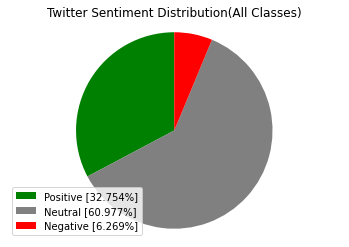

In [21]:
# pi chart of different target classifications
labels = ['Positive ['+str(round(positive, 3))+'%]', 
         'Neutral ['+str(round(neutral, 3))+'%]', 
         'Negative ['+str(round(negative, 3))+'%]']
sizes = [positive, neutral, negative]
colors = ['green', 'grey', 'red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Twitter Sentiment Distribution(All Classes)' )
plt.axis('equal')
plt.savefig('resources/sentiment_dist_all.png')
plt.show()

In [22]:
# percentage of only positive and negative target classification5
positive_adj = df5['sentiment'].value_counts()[1]
negative_adj = df5['sentiment'].value_counts()[0]
total_pos_and_neg = positive_adj + negative_adj
positive_adj = (positive_adj / total_pos_and_neg) * 100
negative_adj = (negative_adj / total_pos_and_neg) * 100

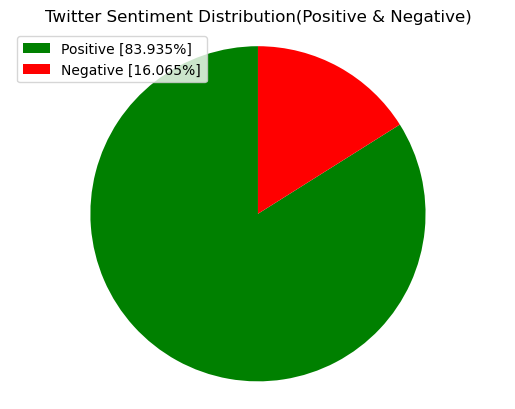

In [23]:
# pi chart of only positive and negative target classifications
labels = ['Positive ['+str(round(positive_adj, 3))+'%]', 'Negative ['+str(round(negative_adj, 3))+'%]']
sizes = [positive, negative]
colors = ['green', 'red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Twitter Sentiment Distribution(Positive & Negative)' )
plt.axis('equal')
plt.savefig('resources/sentiment_dist_pos_neg')
plt.show()

In [24]:
# Examining the frequency distribution.. First, we must compile all the words into a single list.
tweet_tokens = list()
for tweet in df5['tweet']:
    tweet_tokens += nltk.word_tokenize(tweet)
len(tweet_tokens)

106471

In [25]:
# Set of all vocab used in these tweets
tweet_word_set = set()
for tweet in df5['tweet']:
    tweet_word_set.update(nltk.word_tokenize(tweet))
len(tweet_word_set)

7796

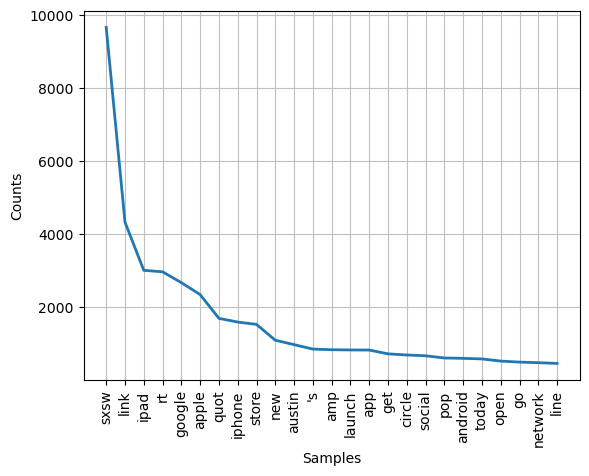

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
# The 9,092 tweets are comprised of 106,471 words after cleaning. suprisingly, there are only 7,796 unique words.
# Let's take a look at the frequency distribution of the most common words.
tweet_dist = nltk.FreqDist(tweet_tokens)
tweet_dist.plot(25, cumulative = False)

### Last Thoughts on Data
The distribution of the raw data set shows that the vast majority of tweets are neutral with only a third being positive and less than 10% being positive. It may be necessary to develop the model as a binary classification and then develop it into a multiclassifcation. Due to the overwhelming amount of 'neutral' tweets, it is actually very important for a model to be able to pick out the neutral tweets. This will insure that only the tweets that have a sentiment are being utilized for whatever task at hand. The frequency distribution shows that there are many words that overlap. Even though there are only approx. 9k tweets, the top 10 most common words are appear more than 1k times. The most common tag, sxsw, is actually a hashtag that denotes a particular confrence that most of these tweets are centered around. I will tweak the model by expirementing with removing one or more of the most common words.

## Modelling
For my models I plan to use the multinomial Naive Bayes classifier, the Random Forest classifier, and the Logistic Regression model. These are all strong models that have yielded strong results when working with text data. When evaluating the models, I utilized two metrics. I utilized F1 weighted for 5-fold cross validation testing. During regular testing, I utilized recall and evaluted this metric for each label of the target. I chose F1 weighted for the cross validation because it encompasses both precision and recall which are important for a project like twitter sentiment. While it is important to extract as many correct identifications as possible, it is also important to penalize false negatives as this will dramatially change the percieved sentiment. F1 weighted balances all the classifications nicely and weights them which helps to combat the class imbalance issues. I chose recall for regular testing since it is a good metric to judge each individual classification by. Since we are trying to assess twitter sentiment, it more detrimental to label positive tweet as negative or a negative tweet as positive, than it is to label a neutral tweet as positive or negative, or vice versa.

In [27]:
# Function for printing out scores nicely, if rec is passed as true, it will print it in the recall format
def score_print(scores, rec = False):
    if (rec):
        print('Recall Scores | Negative: {} | Positive: {} | Neutral: {}'.format(scores[0], scores[1], scores[2]))
    else:
        for score in rf_scores.items():
            print ('{}: \t\t{}'.format(score[0], score[1]))

### Test Splits
I divided the data into three parts. The first split isolated a chunk of the data which will be used for testing at the end. This will ensure that the model is not overfitted or tuned to this specific data set, and will work when tested against unseen data. The second split will be used for training and validation.

In [28]:
## Train Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(df5['tweet'], df5['sentiment'], random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state = 42)

### TF-IDF
Tweets are short bits of information. I think a bag of words approach will be effective for vectorizing these tweets.

In [29]:
target_labels

['negative', 'positive', 'neutral']

In [30]:
# fitting the vectorizor
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(X_train)
tf_idf_data_val = vectorizer.transform(X_val)

In [31]:
# The training data set has 5,114 tweets and 6,046 unique words
tf_idf_data_train.shape

(5114, 6046)

### Multinomial Naive Bayes
On the first iteration of this model, both the training and testing models did not score well. This was because the training model was trained on a lot of neutral tweets. This greatly lowered the models predicting power in pulling out the positive and negative tweets.

In [32]:
# Multinomial Naive Bayes
nb_classifier = MultinomialNB()

In [33]:
# Fitting Model
nb_classifier.fit(tf_idf_data_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_val_preds = nb_classifier.predict(tf_idf_data_val)

In [34]:
# Calculate Recall Scores
nb_train_score = recall_score(y_train, nb_train_preds, average = None)
nb_val_score = recall_score(y_val, nb_val_preds, average = None)

Recall Scores | Negative: 0.013377926421404682 | Positive: 0.4227740763173834 | Neutral: 0.9920986093552465


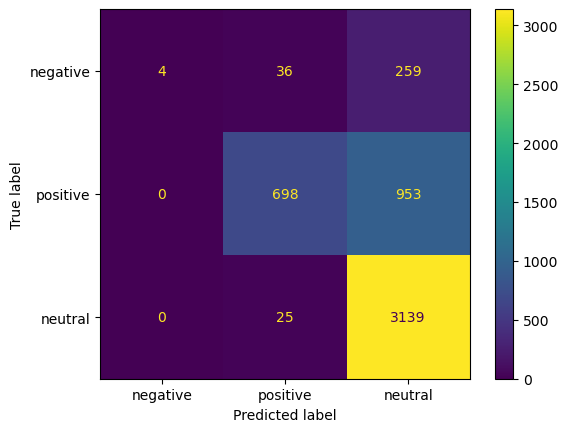

In [35]:
# Confusion Matrix from Training data
plot_confusion_matrix(nb_classifier, tf_idf_data_train, y_train, display_labels = target_labels)
score_print(nb_train_score, rec = True)

Recall Scores | Negative: 0.0 | Positive: 0.18439716312056736 | Neutral: 0.9676787463271302


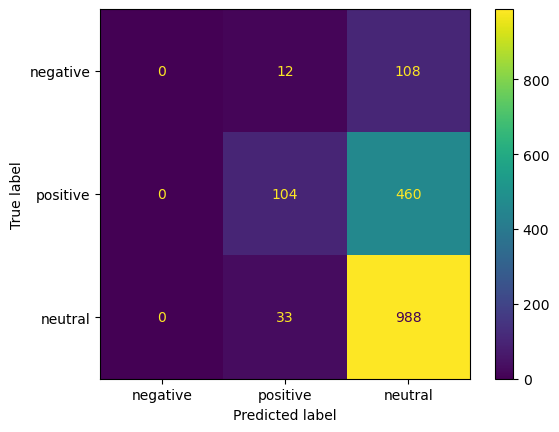

In [36]:
# Confusion Matrix from Validation data
plot_confusion_matrix(nb_classifier, tf_idf_data_val, y_val, display_labels = target_labels)
score_print(nb_val_score, rec = True)

In [37]:
# k-fold cross val
nb_first_pipe = make_pipeline(vectorizer, nb_classifier)
nb_scores = cross_validate(nb_first_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

In [38]:
for score in nb_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[0.07169843 0.06870151 0.06877804 0.06924772 0.06858373]
score_time: 		[0.01655817 0.0160377  0.01603055 0.01613498 0.01632977]
test_f1_weighted: 		[0.56006914 0.57795303 0.57675704 0.58069414 0.54945847]


### Initial Thoughts on this Model

The Multinomial Naive Bayes model is usually a strong model. In this first iteration, this model is not performing well. Since this model works by calculating the probabilities of words being present and buckets the tweet according to that, I believe the sheer volume of the neutral category is greatly crippling this model. This is because the neutral category most likely contains more words and similar words to those tweets that are positive or negative. Thus, the model has a very high tendency to bucket tweets as neutral when they are not. This is demonstrated by the recall scores for the testing model which are 0 for negative tweets and just a mere .184 for positive tweets. That means majority of negative and positive tweets are being reported as false negatives(neutral tweets). I believe resampling will improve this model and help reduce the noise caused by the neutral category.

### Random Forest Model
The way this model trained to the data was near perfect. Subsequently, it outperformed the multinomialMB model in almost every category except the neutral one, which is likely a good thing. My hypothesis is that the models are getting overfit to tweets that display neutral sentiment. I will try resampling the data and assessing wether this improves the performance of the model.

In [39]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators = 100)

In [40]:
# Fitting Model
rf_classifier.fit(tf_idf_data_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_val_preds = rf_classifier.predict(tf_idf_data_val)

In [41]:
# Calculate Recall Scores
rf_train_score = recall_score(y_train, rf_train_preds, average = None)
rf_val_score = recall_score(y_val, rf_val_preds, average = None)

Recall Scores | Negative: 0.9899665551839465 | Positive: 0.9903089036947305 | Neutral: 0.9962073324905183


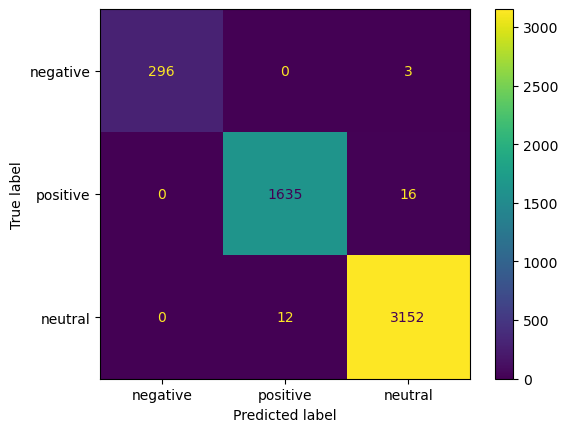

In [42]:
# Confusion Matrix from Training data
plot_confusion_matrix(rf_classifier, tf_idf_data_train, y_train, display_labels = target_labels)
score_print(rf_train_score, rec = True)

Recall Scores | Negative: 0.125 | Positive: 0.3776595744680851 | Neutral: 0.8942213516160626


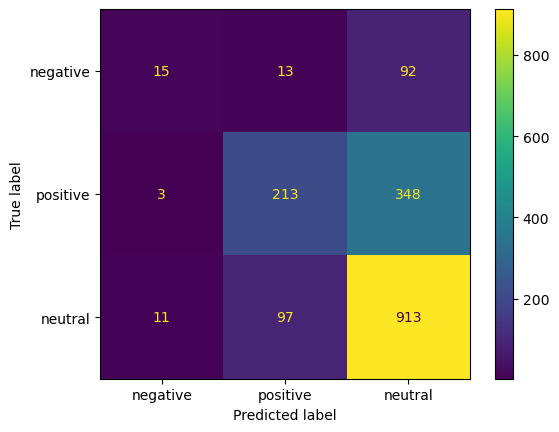

In [43]:
# Confusion Matrix from Validation data
plot_confusion_matrix(rf_classifier, tf_idf_data_val, y_val, display_labels = target_labels)
score_print(rf_val_score, rec = True)

In [44]:
# k-fold cross val
rf_first_pipe = make_pipeline(vectorizer, rf_classifier)
rf_scores = cross_validate(rf_first_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

In [45]:
for score in rf_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[3.87345028 3.76192021 3.85295868 3.88561964 3.81300855]
score_time: 		[0.08762479 0.08805943 0.08930445 0.08711386 0.08760977]
test_f1_weighted: 		[0.63869004 0.65840854 0.64062723 0.66397281 0.6382054 ]


### Initial Thoughts on this Model

This model is definitely overfit to the training data. Although hypertuning the parameters may resolve this, it could also because of the noisy neutral category. Will expirement with oversampling and possibly a grid search for the best settings. 

### Logistic Regression Model
This model performed the poorest in predicting tweets with negative sentiment, but performed the best when predicting tweets with positive sentiment. Like the rest of the models, the neutral tweet section is really skewing the results, so I believe oversampling will benefit this model.

In [46]:
# Logistic Regression
lr_classifier = LogisticRegression(random_state = 42)

In [47]:
# Fitting Model
lr_classifier.fit(tf_idf_data_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_data_train)
lr_val_preds = lr_classifier.predict(tf_idf_data_val)

In [48]:
lr_train_score = recall_score(y_train, lr_train_preds, average = None)
lr_val_score = recall_score(y_val, lr_val_preds, average = None)

Recall Scores | Negative: 0.0903010033444816 | Positive: 0.6596002422774077 | Neutral: 0.9633375474083439


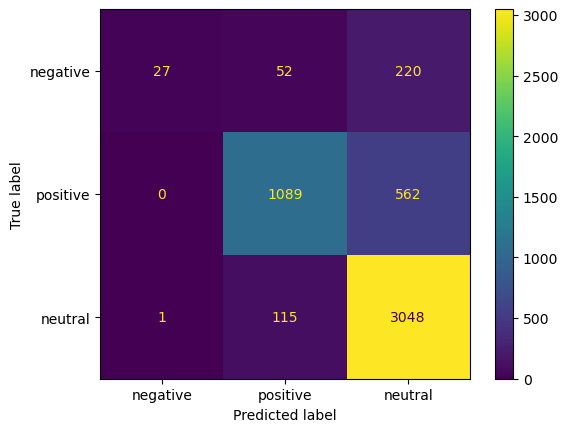

In [49]:
# Confusion Matrix from Training data
plot_confusion_matrix(lr_classifier, tf_idf_data_train, y_train, display_labels = target_labels)
score_print(lr_train_score, rec = True)

Recall Scores | Negative: 0.058333333333333334 | Positive: 0.3971631205673759 | Neutral: 0.8824681684622919


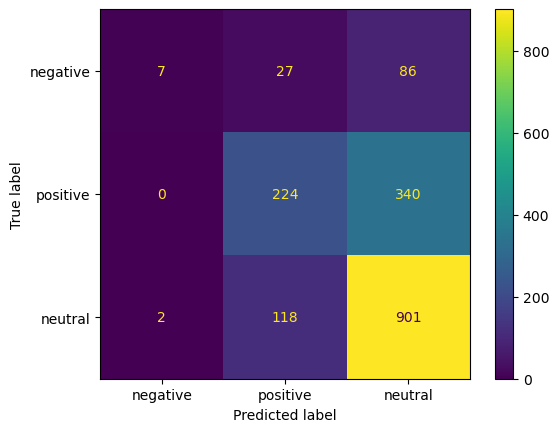

In [50]:
# Confusion Matrix from Validation data
plot_confusion_matrix(lr_classifier, tf_idf_data_val, y_val, display_labels = target_labels)
score_print(lr_val_score, rec = True)

In [51]:
# k-fold cross val
lr_first_pipe = make_pipeline(vectorizer, lr_classifier)
lr_scores = cross_validate(lr_first_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [52]:
for score in lr_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[0.75926065 1.05175114 1.05815411 1.04871368 0.84105444]
score_time: 		[0.02987409 0.03282118 0.03307772 0.03387904 0.03252459]
test_f1_weighted: 		[0.64793652 0.67129897 0.65098233 0.66975742 0.63793293]


### Initial Thoughts on this Model

Although this model does not seem to have any massive overfitting issues, its performance is just subpar to the random forest model. However, Logistic Regression is good model to use with TF-IDF. Possibly if the neutral and negative categories were lumped together, the logistic regression model may perform much better. Will expirement with oversampling and possibly hypertuning.

## Oversampling
Oversampling was implemented in order to combat the class imbalance. The Naive Bayes model and Random Forest model both benefitted slightly from oversampling. The Logistic Regression model did not benefit from oversampling.

In [53]:
# Oversampling on Naive Bayesian model
nb_oversample_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), nb_classifier)
nb_scores_of = cross_validate(nb_oversample_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

In [54]:
# OLD SCORE without oversampling
for score in nb_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[0.07169843 0.06870151 0.06877804 0.06924772 0.06858373]
score_time: 		[0.01655817 0.0160377  0.01603055 0.01613498 0.01632977]
test_f1_weighted: 		[0.56006914 0.57795303 0.57675704 0.58069414 0.54945847]


In [55]:
# NEW SCORE with oversampling
for score in nb_scores_of.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[0.23954868 0.23323298 0.22096658 0.21973801 0.22006631]
score_time: 		[0.01618457 0.01667356 0.01618671 0.0163877  0.01630878]
test_f1_weighted: 		[0.60883777 0.61778141 0.57489259 0.62766348 0.60043845]


It seems that oversampling slightly improved the f1 scores for the multinomial nb model.

In [56]:
# Oversampling on Random Forest model
rf_oversample_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), rf_classifier)
rf_scores_of = cross_validate(rf_oversample_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

In [57]:
# OLD SCORE without oversampling
for score in rf_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[3.87345028 3.76192021 3.85295868 3.88561964 3.81300855]
score_time: 		[0.08762479 0.08805943 0.08930445 0.08711386 0.08760977]
test_f1_weighted: 		[0.63869004 0.65840854 0.64062723 0.66397281 0.6382054 ]


In [58]:
# NEW SCORE with oversampling
for score in rf_scores_of.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[6.92931509 6.86702704 6.90069032 7.0283947  6.81055546]
score_time: 		[0.08202958 0.08498597 0.08573604 0.08505893 0.08245277]
test_f1_weighted: 		[0.66491419 0.66130175 0.65431049 0.68725327 0.65909492]


It is just barely, but the random forest model also benefitted

In [59]:
# Oversampling on Logistic Regression Model
lr_oversample_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), lr_classifier)
lr_scores_of = cross_validate(lr_oversample_pipe, X_train_full, y_train_full, scoring=['f1_weighted'], cv=5)

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [60]:
# OLD SCORE without oversampling
for score in lr_scores.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[0.75926065 1.05175114 1.05815411 1.04871368 0.84105444]
score_time: 		[0.02987409 0.03282118 0.03307772 0.03387904 0.03252459]
test_f1_weighted: 		[0.64793652 0.67129897 0.65098233 0.66975742 0.63793293]


In [61]:
# NEW SCORE with oversampling
for score in lr_scores_of.items():
    print ('{}: \t\t{}'.format(score[0], score[1]))

fit_time: 		[1.7683928  1.66448832 1.72837996 1.87116027 1.6628809 ]
score_time: 		[0.05202818 0.0338881  0.03238249 0.0332129  0.04174757]
test_f1_weighted: 		[0.65564165 0.67235033 0.65370604 0.67845375 0.63808973]


It seems that all three, including logistic regression benefited from oversampling

## Final Testing

### Multinomial Naive Bayes

In [62]:
nb_final_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), nb_classifier)

In [63]:
nb_final_pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('multinomialnb', MultinomialNB())])

In [64]:
nb_test_preds = nb_final_pipe.predict(X_test)
nb_test_score = recall_score(y_test, nb_test_preds, average = None)

Recall Scores | Negative: 0.4966887417218543 | Positive: 0.63564875491481 | Neutral: 0.5592347314201619


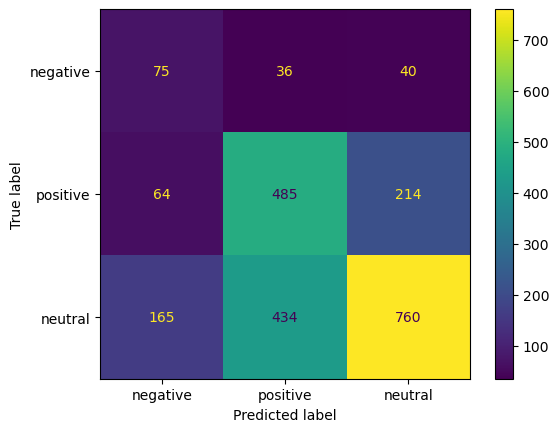

In [65]:
# Confusion Matrix
plot_confusion_matrix(nb_final_pipe, X_test, y_test, display_labels = target_labels)
score_print(nb_test_score, rec = True)

This model is performing competently now. It seems that it is able to predict positive tweets the best and it is actually predicting neutral tweets as positive ones. It is predicting negative ones competently as well. It needs some work predicting the neutral tweets.

### Random Forest

In [66]:
rf_final_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), rf_classifier)

In [67]:
rf_final_pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier', RandomForestClassifier())])

In [68]:
rf_test_preds = rf_final_pipe.predict(X_test)
rf_test_score = recall_score(y_test, rf_test_preds, average = None)

Recall Scores | Negative: 0.23841059602649006 | Positive: 0.4954128440366973 | Neutral: 0.8042678440029434


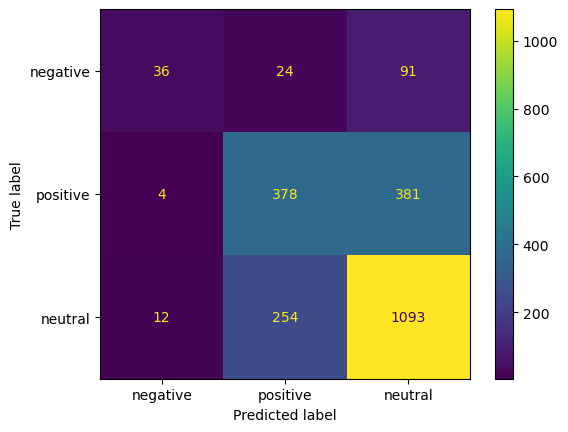

In [69]:
# Confusion Matrix
plot_confusion_matrix(rf_final_pipe, X_test, y_test, display_labels = target_labels)
score_print(rf_test_score, rec = True)
#plt.savefig('resources/rf_confusion')

This model benefitted greatly from oversampling. It is performing much better but it is not predicting the negative tweets well as the recall score is a mere 0.24. However, it is able to prevent predicting neutral tweets as false negatives as much as the multinomial mb model.

This model is working okay. It is most likely suffering from being overfit like it was previously. The next step is to run a comprehensive grid search and experiment with different tunings.

### Logistic Regression

In [70]:
lr_final_pipe = make_pipeline(vectorizer, SMOTE(random_state = 42), lr_classifier)

In [71]:
lr_final_pipe.fit(X_train_full, y_train_full)

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression(random_state=42))])

In [72]:
lr_test_preds = lr_final_pipe.predict(X_test)
lr_test_score = recall_score(y_test, lr_test_preds, average = None)

Recall Scores | Negative: 0.4768211920529801 | Positive: 0.5871559633027523 | Neutral: 0.6799116997792495


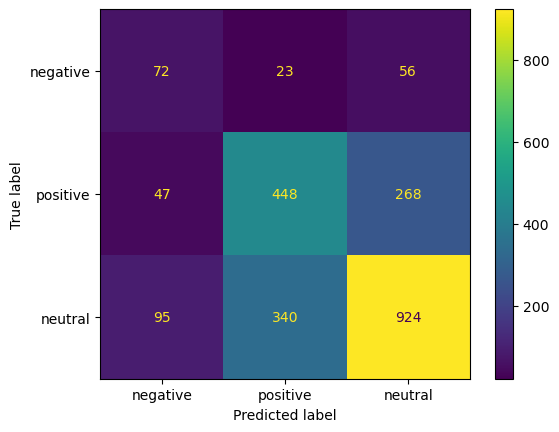

In [73]:
# Confusion Matrix
plot_confusion_matrix(lr_final_pipe, X_test, y_test, display_labels = target_labels)
score_print(lr_test_score, rec = True)

This is probably the best performing model overall. It is predicting positive tweets at a slightly diminished rate than the multinomial mb model but is highly competent in predicting negatives and is able to predict neutrals at a much better rate.

## Conclusion and Next Steps
These models show some success in predicting Twitter sentiment. At this time, I would reccomend the Logistic Regression Classification model. This model was relatively successful in extracting both negative and positive tweets, and is conservative in how many inaccuracies it is making compared to the rest of the models. It has recall scores of:

In [74]:
score_print(lr_test_score, rec = True)

Recall Scores | Negative: 0.4768211920529801 | Positive: 0.5871559633027523 | Neutral: 0.6799116997792495


This is fairly good across the board and is a good foundation since the data has just been cleaned and oversampled. A grid search would be the most beneficial change to this model. It may also be worth looking into the top 50 words and further exploring the underlying reasons behind why the model is confusing certain tweets.

That being said I would like to point out a few flaws and potentially next steps for this project.

The Data: The data seems to be very heavily grounded in tech, with the number one key word being a hashtag for a tech confrence. Furthermore, iPad, Google, Apple, and iPhone are extremely prevalent key words. I believe this model is possibly associating certain tech words or brands with positive or negative sentiment. The process must be repeated with a larger data set that has a diverse field of interest.

Further Tuning: Although I believe my concerns about the data are more pressing, all of these models definitely could have benefitted from an extensive grid search. This would have allowed all the models to be tuned to the precise settings that would yield the greatest extraction of each target.

More Models and Embedding: There are some more complex models for NLP research as well as strategies to increase deep learning and yield better results. I believe that this project is a good base and would highly benefit from these strategies.